In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model

In [3]:
!pip install scikit-learn

In [4]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [7]:
df0=pd.read_csv('sp500sub.csv',parse_dates=True,index_col='Date')

In [8]:
df=df0[df0['Name']=='SBUX'][['Close']].copy()

In [10]:
df['LogClose']=np.log(df['Close'])

In [11]:
df['DiffLogClose']=df['LogClose'].diff()

In [14]:
Ntest=21
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [16]:
scaler=StandardScaler()
train_scaled=scaler.fit_transform(train[['DiffLogClose']])
test_scaled=scaler.transform(test[['DiffLogClose']])

In [17]:
train_idx=df.index<=train.index[-1]
test_idx=~train_idx

In [18]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [19]:
#make supervised learning dataset
series=df['ScaledLogReturn'].dropna().to_numpy()

T=21
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)

In [20]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

In [22]:
#Basic ANN Model
i=Input((T,))
x=Dense(32,activation='relu')(i)
x=Dense(1)(x)
model=Model(i,x)

In [23]:
model.compile(loss='mse',optimizer='adam')

In [26]:
r=model.fit(Xtrain,Ytrain,epochs=200,validation_data=(Xtest,Ytest))

Epoch 1/200
70/70 [==============================] - 2s 9ms/step - loss: 1.7433 - val_loss: 1.1924
Epoch 2/200
70/70 [==============================] - 1s 10ms/step - loss: 1.1798 - val_loss: 1.1387
Epoch 3/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0787 - val_loss: 1.1459
Epoch 4/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0389 - val_loss: 1.1756
Epoch 5/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0180 - val_loss: 1.1772
Epoch 6/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9988 - val_loss: 1.1542
Epoch 7/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9812 - val_loss: 1.1577
Epoch 8/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9703 - val_loss: 1.1334
Epoch 9/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9602 - val_loss: 1.1250
Epoch 10/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9475 - val_loss: 1.1271
Epoch 11

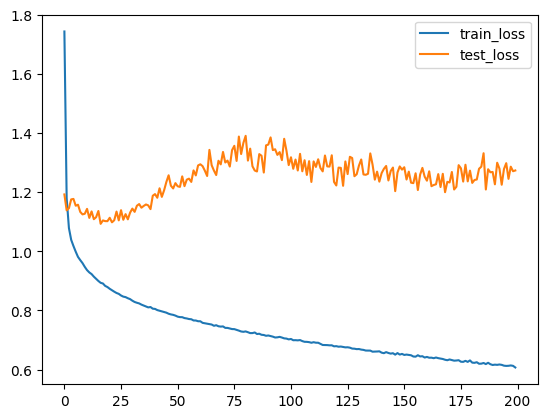

In [27]:
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='test_loss')
plt.legend()
plt.show()

In [28]:
train_idx[:T+1]=False

In [29]:
Ptrain=model.predict(Xtrain)
Ptest=model.predict(Xtest)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

1/1 [==============================] - 0s 21ms/step


In [30]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

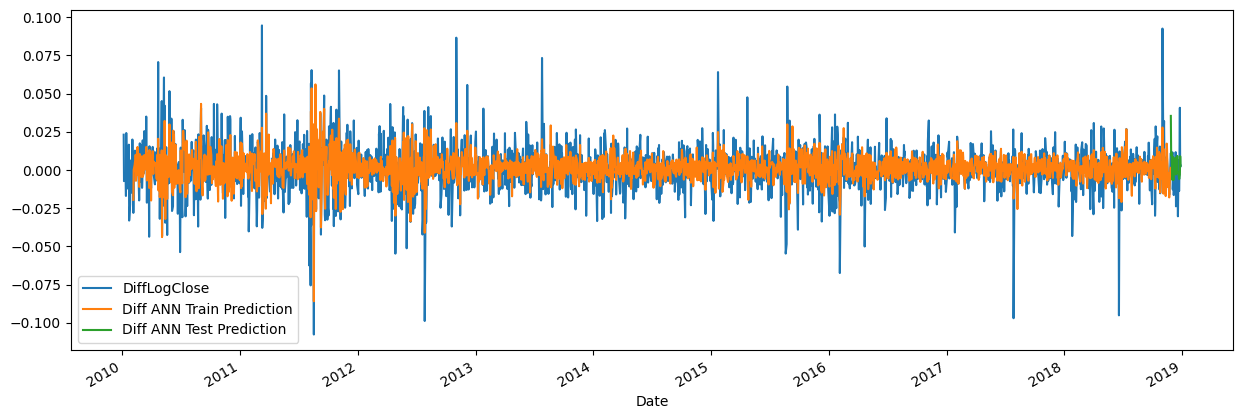

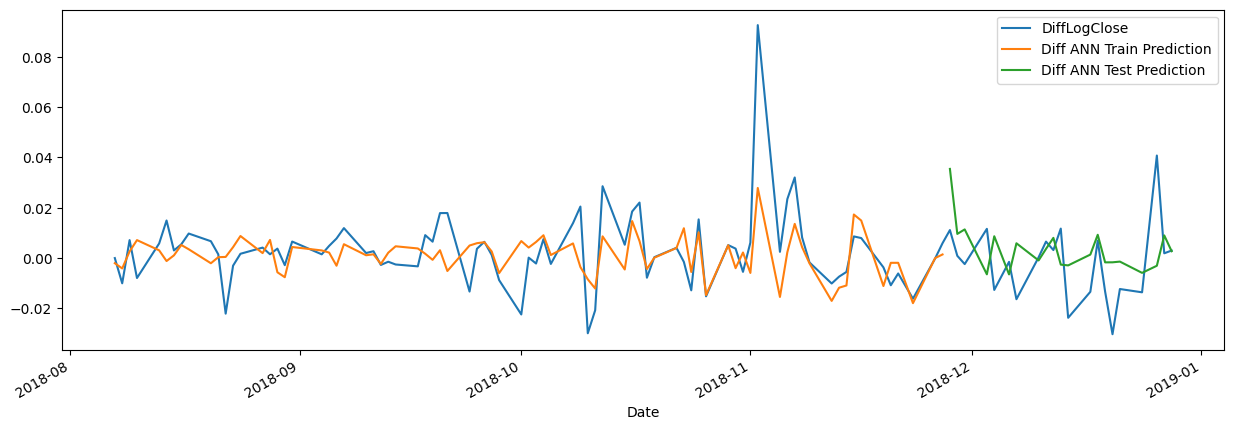

In [38]:
cols = ['DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15,5));
df[cols][-100:].plot(figsize=(15, 5));

In [39]:
# Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [40]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

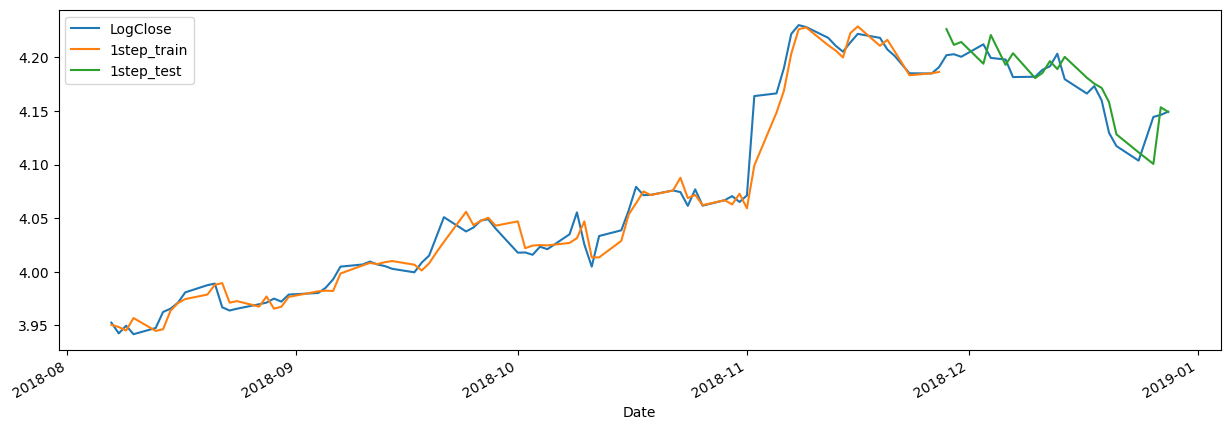

In [41]:
# plot 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [42]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


1/1 [==============================] - 0s 46ms/step


In [43]:
# unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1, 1)).flatten()

In [45]:
# Last-known train value
last_train = train.iloc[-1]['LogClose']

In [46]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

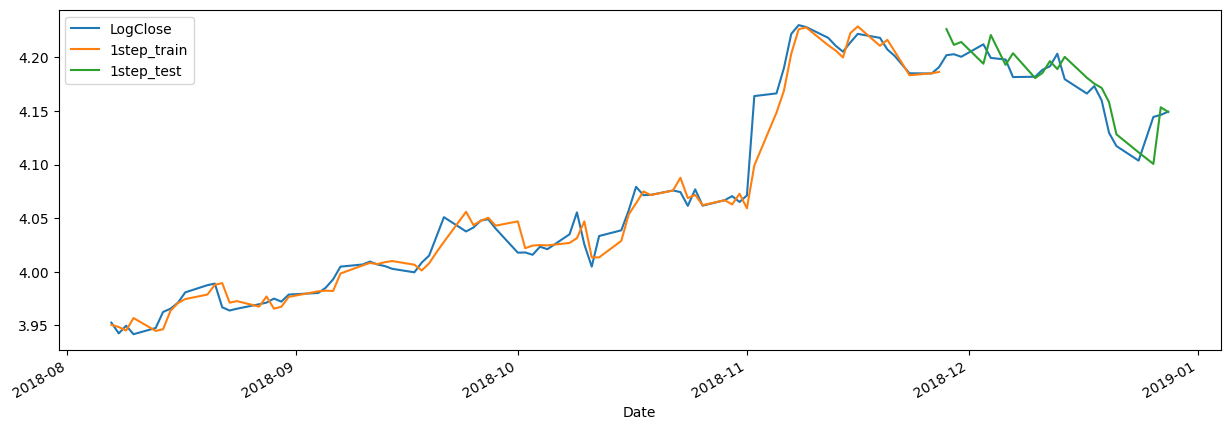

In [47]:
# plot 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [48]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2221, 21) Y.shape (2221, 21)


In [49]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [50]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [51]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [52]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=100,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
70/70 [==============================] - 1s 5ms/step - loss: 1.2798 - val_loss: 1.5564
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 1.1309 - val_loss: 1.3931
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0766 - val_loss: 1.2998
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0480 - val_loss: 1.2206
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0309 - val_loss: 1.1858
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0198 - val_loss: 1.1603
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0121 - val_loss: 1.1552
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0062 - val_loss: 1.1371
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0018 - val_loss: 1.1240
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9980 - val_loss: 1.1301
Epoch 11/

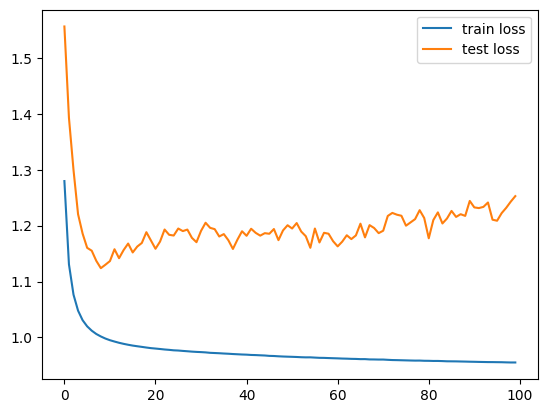

In [53]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [54]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

1/1 [==============================] - 0s 23ms/step


In [55]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [56]:
# unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [57]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

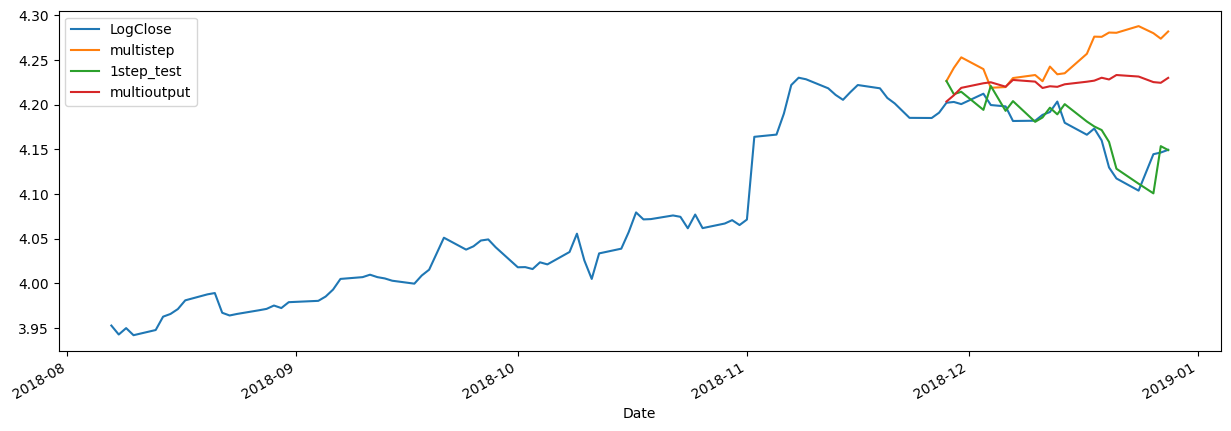

In [58]:
# plot all forecasts
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [59]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.0190345943686352
multi-output MAPE: 0.012146571988746154
